In [50]:
import re
import json
import os

def preprocess(text):
    punctuations = "，。！？；：“”（）"
    input_text = ""
    punctuation_indices = []
    punctuation_types = []

    for idx, char in enumerate(text):
        if char in punctuations:
            punctuation_indices.append(len(input_text))
            punctuation_types.append(char)
        else:
            input_text += char

    return input_text, punctuation_indices, punctuation_types


In [74]:
import os
import json

def process_folder(folder_path, output_file):
    data_points = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                for i, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue
                    input_text, indices, types = preprocess(line)
                    data_point = {
                        "filename": filename,
                        "line_number": i + 1,
                        "input_text": input_text,
                        "punctuation_indices": indices,
                        "punctuation_types": types
                    }
                    data_points.append(data_point)

    # Écriture dans le fichier JSONL
    with open(output_file, 'w', encoding='utf-8') as out_f:
        for dp in data_points:
            out_f.write(json.dumps(dp, ensure_ascii=False) + "\n")

    # Affichage du résumé du traitement
    print(f"{len(data_points)} points de données traités, fichier de sortie : {output_file}")


In [75]:
if __name__ == "__main__":
    folder_path = "Corpus/十國春秋_cleaned"
    output_file = "processed_data_sgcq.jsonl"
    process_folder(folder_path, output_file)

6575 points de données traités, fichier de sortie : processed_data_sgcq.jsonl


In [53]:
import json
from tqdm import tqdm

# Mapping des signes de ponctuation en étiquettes numériques
punctuation_map = {
    "，": 1,
    "。": 2,
    # "？": 3,
    # "！": 4,
    # "；": 5,
    "：": 3,
    # "“": 7,
    # "”": 7,
    # "‘": 8,
    # "’": 8,
    # "（": 9,
    # "）": 9
}

# Construction du jeu de données au niveau caractère
def build_dataset(jsonl_path, vocab=None):
    all_X = []
    all_y = []
    char2idx = {} if vocab is None else vocab
    idx = 1  # 0 réservé pour le padding

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Processing"):
            data = json.loads(line)
            input_text = data["input_text"]
            punct_indices = data["punctuation_indices"]
            punct_types = data["punctuation_types"]

            # Encodage de input_text en séquence d’IDs de caractères
            X = []
            for ch in input_text:
                if vocab is None:
                    if ch not in char2idx:
                        char2idx[ch] = idx
                        idx += 1
                X.append(char2idx.get(ch, 0))  # 0 pour caractère hors vocabulaire

            # Construction de la séquence d’étiquettes alignée caractère par caractère
            y = [0] * len(input_text)
            for i, punct in zip(punct_indices, punct_types):
                if i < len(y):  # Vérification de sécurité
                    y[i] = punctuation_map.get(punct, 0)  # ponctuation inconnue → 0

            all_X.append(X)
            all_y.append(y)

    return all_X, all_y, char2idx

# Appel de la fonction pour construire les données
X, y, char2idx = build_dataset("processed_data_sgcq.jsonl")

# Sauvegarde du dictionnaire char2idx
with open("char2idx.json", "w", encoding="utf-8") as f:
    json.dump(char2idx, f, ensure_ascii=False)


Processing: 6575it [00:00, 102482.96it/s]


In [54]:
jsonl_file = "processed_data_sgcq.jsonl"
X, y, vocab = build_dataset(jsonl_file)

print("Nombre d'échantillons :", len(X))
print("Première séquence d'entrée (IDs de caractères) :", X[0])
print("Première séquence d'étiquettes :", y[0])
print("Taille du vocabulaire :", len(vocab))


Processing: 0it [00:00, ?it/s]

Processing: 6575it [00:00, 70098.75it/s]

Nombre d'échantillons : 6575
Première séquence d'entrée (IDs de caractères) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 7, 19]
Première séquence d'étiquettes : [0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
Taille du vocabulaire : 5139


In [55]:
# !pip install tensorflow

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def build_punctuation_model(vocab_size, num_classes, embedding_dim=128, lstm_units=128):
    # Définition de l’entrée du modèle : séquence d’IDs de caractères de longueur variable
    input_seq = Input(shape=(None,), dtype='int32')  # [batch_size, seq_len]

    # Couche d’embedding pour transformer les IDs en vecteurs denses
    x = Embedding(input_dim=vocab_size + 1,  # +1 pour l’index réservé au padding
                  output_dim=embedding_dim,
                  mask_zero=True)(input_seq)
    # LSTM bidirectionnel pour capturer le contexte avant et arrière
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # Couche de Dropout pour réduire le surapprentissage
    x = Dropout(0.4)(x)
    # Couche Dense appliquée à chaque pas de temps pour prédire la classe de ponctuation
    x = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

    # Compilation du modèle avec l’optimiseur Adam et une perte catégorielle
    model = Model(inputs=input_seq, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Construction des données d’entraînement
X, y, char2idx = build_dataset("processed_data_sgcq.jsonl")
# Calcul de la longueur maximale des séquences pour le padding
max_len = max(len(seq) for seq in X)
# Padding des séquences d’entrée et des étiquettes
X_pad = pad_sequences(X, maxlen=max_len, padding='post')
y_pad = pad_sequences(y, maxlen=max_len, padding='post')
# Ajout d’une dimension pour la compatibilité avec 'sparse_categorical_crossentropy'
y_pad = np.expand_dims(y_pad, -1)


Processing: 0it [00:00, ?it/s]

Processing: 6575it [00:00, 73294.25it/s]


In [57]:
NUM_CLASSES = 4

model = build_punctuation_model(vocab_size=len(vocab), num_classes=NUM_CLASSES)


In [58]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_pad, y_pad, batch_size=32, epochs=20, validation_split=0.1, callbacks=[early_stop])


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - accuracy: 0.9611 - loss: 0.6502 - val_accuracy: 0.9703 - val_loss: 0.3931
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 57s 306ms/step - accuracy: 0.9691 - loss: 0.3710 - val_accuracy: 0.9747 - val_loss: 0.3100
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 49s 267ms/step - accuracy: 0.9726 - loss: 0.3040 - val_accuracy: 0.9757 - val_loss: 0.2871
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 50s 272ms/step - accuracy: 0.9757 - loss: 0.2682 - val_accuracy: 0.9765 - val_loss: 0.2776
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 277ms/step - accuracy: 0.9770 - loss: 0.2474 - val_accuracy: 0.9767 - val_loss: 0.2751
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 294ms/step - accuracy: 0.9786 - loss: 0.2324 - val_accuracy: 0.9766 - val_loss: 0.2762
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 299ms/step - accuracy: 0.9798 - loss: 0.2182 - val_accuracy: 0.9762 - val_loss: 0.2893


206/206 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step


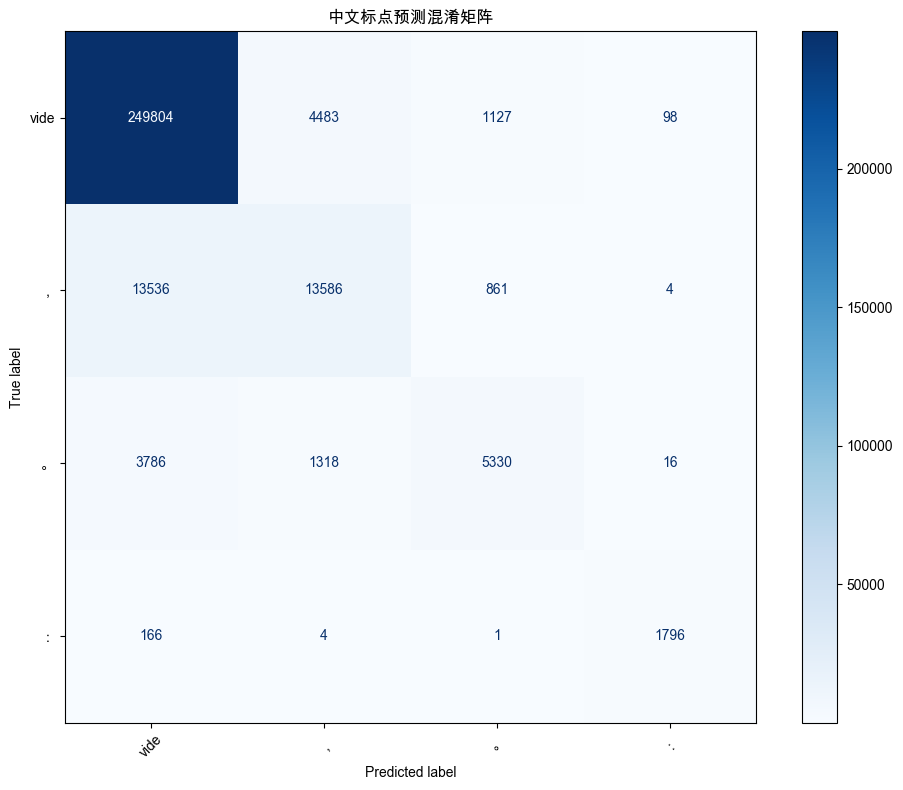


Rapport de classification (Précision / Rappel / F1-Score) :

              precision    recall  f1-score   support

        vide     0.9346    0.9777    0.9556    255512
           ，     0.7006    0.4854    0.5735     27987
           。     0.7282    0.5100    0.5999     10450
           ：     0.9383    0.9131    0.9255      1967

    accuracy                         0.9142    295916
   macro avg     0.8254    0.7216    0.7637    295916
weighted avg     0.9052    0.9142    0.9067    295916


Exactitude globale : 0.9142


In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Configuration des polices pour le chinois (ajuster selon le système)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Peut aussi être SimHei, Noto Sans CJK SC
plt.rcParams['axes.unicode_minus'] = False

# ===== 1. Table de correspondance des ponctuations =====
punctuation_map = {
    "，": 1,
    "。": 2,
    # "？": 3,
    # "！": 4,
    # "；": 5,
    "：": 3,
    # "“": 7,
    # "”": 7,
    # "‘": 8,
    # "’": 8,
    # "（": 9,
    # "）": 9
}
idx2punct = {v: k for k, v in punctuation_map.items()}
idx2punct[0] = "vide"

# ===== 2. Prédiction du modèle =====
y_pred_prob = model.predict(X_pad)
y_pred = np.argmax(y_pred_prob, axis=-1)

# ===== 3. Aplatissage et omission du padding =====
y_true_flat = []
y_pred_flat = []

for i in range(len(y_pad)):
    for j in range(len(y_pad[i])):
        if X_pad[i][j] != 0:
            y_true_flat.append(y_pad[i][j][0])
            y_pred_flat.append(y_pred[i][j])

# ===== 4. Types et noms des étiquettes =====
labels = sorted(set(y_true_flat + y_pred_flat))
display_labels = [idx2punct.get(i, str(i)) for i in labels]

# ===== 5. Matrice de confusion =====
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)

# Configuration des polices
for label in ax.get_xticklabels():
    label.set_fontname("Arial Unicode MS")
for label in ax.get_yticklabels():
    label.set_fontname("Arial Unicode MS")

plt.title("中文标点预测混淆矩阵", fontname="Arial Unicode MS")
plt.tight_layout()
plt.show()

# ===== 6. Affichage du rapport de classification (Précision / Rappel / F1-Score) =====
target_names = display_labels
print("\nRapport de classification (Précision / Rappel / F1-Score) :\n")
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=target_names, digits=4))

# ===== 7. Exactitude globale =====
acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"\nExactitude globale : {acc:.4f}")


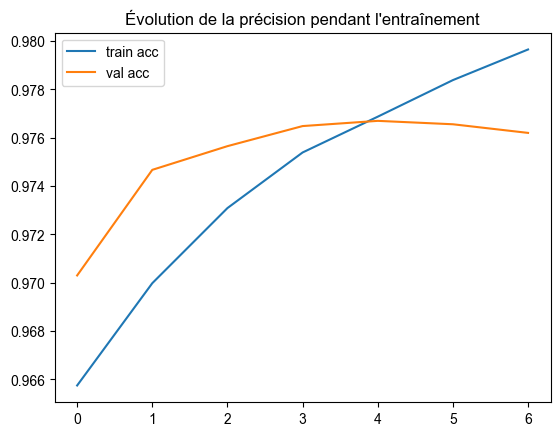

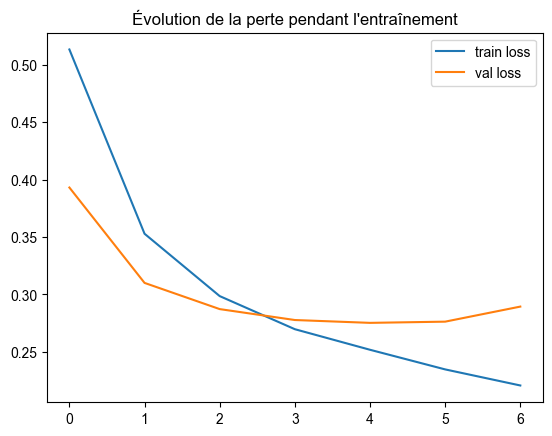

In [67]:
import matplotlib.pyplot as plt

# Supposons que 'history' soit l’objet retourné par l’entraînement Keras
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Évolution de la précision pendant l'entraînement")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Évolution de la perte pendant l'entraînement")
plt.show()


In [68]:
model.save("model_simple.h5")

with open("char2idx.json", "r", encoding="utf-8") as f:
    char2idx = json.load(f)


In [69]:
# Si vous avez déjà punctuation_map, vous pouvez automatiquement construire la correspondance inverse :
punctuation_id2char = {0: "", 1: "，", 2: "。", 
                    #    3: "？", 4: "！", 5: "；", 
                       3: "：", 
                    #    7: "”", 8: "’", 9: "）"
                    }

# Suivi des états des ponctuations gauche/droite (pour appariement automatique ouverture/fermeture)
# quote_states = {
#     7: True,  # True signifie que la prochaine fois c’est une guillemet ouvrante “
#     8: True,  # ‘
#     9: True   # （
# }

# Fonction utilisée lors de l'inférence
def resolve_punctuation(label_id):
    if label_id not in [7, 8, 9]:
        # Ponctuations asymétriques : correspondance directe
        return {
            1: "，", 2: "。", 
            # 3: "？", 4: "！", 5: "；", 
            3: "："
        }.get(label_id, "")
    
    # # Ponctuations symétriques : selon l'état, renvoyer ouverture ou fermeture
    # if label_id == 7:
    #     result = "“" if quote_states[7] else "”"
    #     quote_states[7] = not quote_states[7]
    #     return result
    # elif label_id == 8:
    #     result = "‘" if quote_states[8] else "’"
    #     quote_states[8] = not quote_states[8]
    #     return result
    # elif label_id == 9:
    #     result = "（" if quote_states[9] else "）"
    #     quote_states[9] = not quote_states[9]
    #     return result


In [70]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_punctuation(text, model, char2idx, punctuation_id2char, max_len=200):
    # Conversion du texte en liste de caractères
    chars = list(text)
    # Encodage des caractères en IDs, 0 si caractère hors vocabulaire
    input_ids = [char2idx.get(ch, 0) for ch in chars]
    # Padding de la séquence d’IDs à la longueur max_len
    input_ids = pad_sequences([input_ids], maxlen=max_len, padding='post')

    # Prédiction des probabilités, puis sélection des classes
    preds = model.predict(input_ids)[0]  # shape: (seq_len, num_classes)
    pred_classes = np.argmax(preds, axis=-1)

    # Reconstruction du texte avec ponctuation insérée
    result = ""
    for i, ch in enumerate(chars):
        result += ch
        label = pred_classes[i]
        if label != 0:  # si une ponctuation est prédite
            result += resolve_punctuation(label)

    return result


In [71]:
test_text = "先帝創業未半而中道崩殂今天下三分益州疲弊"
output_text = predict_punctuation(test_text, model, char2idx, punctuation_id2char)
print("原文（无标点）:", test_text)
print("预测（加标点）:", output_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
原文（无标点）: 先帝創業未半而中道崩殂今天下三分益州疲弊
预测（加标点）: 先帝創業未半而，中道崩殂今，天下三分益，州疲弊


In [72]:
test_text = "親賢臣遠小人此先漢所以興隆也親小人遠賢臣此後漢所以傾頹也"
output_text = predict_punctuation(test_text, model, char2idx, punctuation_id2char)
print("原文（无标点）:", test_text)
print("预测（加标点）:", output_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
原文（无标点）: 親賢臣遠小人此先漢所以興隆也親小人遠賢臣此後漢所以傾頹也
预测（加标点）: 親賢臣遠小人此先漢所以興隆也親。小人遠賢臣此後漢所以傾頹也
